# Post-treatment
# ABC-SMC
# Sensitivity Analysis

In [1]:
using CSV, DataFrames, Statistics, Plots, StatsPlots

In [2]:
scenarios = ["H=0 ; C=0", "H=1 ; C=0", "H=0 ; C=1", "H=1 ; C=1"];

# Configurationb - ACB-SMC Sampler

In [3]:
id_config = ""

""

In [4]:
dir = "../../ABC_SMC/results$id_config/"

"../../ABC_SMC/results/"

In [5]:
nb_iter = 17;

In [6]:
list_params = [:p1_1, :p1_2, :p1_3, :mu_1, :sig_1, 
                :rho_H_1, :p2_2, :p2_3, 
                :mu_2, :sig_2, :p3_3, :mu_3, :sig_3, :mu_4, :sig_4, 
                :recovery_rate, :rho_C_sisters_A]

17-element Vector{Symbol}:
 :p1_1
 :p1_2
 :p1_3
 :mu_1
 :sig_1
 :rho_H_1
 :p2_2
 :p2_3
 :mu_2
 :sig_2
 :p3_3
 :mu_3
 :sig_3
 :mu_4
 :sig_4
 :recovery_rate
 :rho_C_sisters_A

# Load results

In [7]:
arr_df = [];

In [8]:
for iter in 1:nb_iter+1
    df = CSV.read(string(dir, "step_",iter-1,".csv"), DataFrame) 
    push!(arr_df, df[(df[:,:C].==1) .* (df[:,:H].==1),list_params])    
end

# Display intermediate posterior distributions

In [9]:
choice_parameter = :mu_2

:mu_2

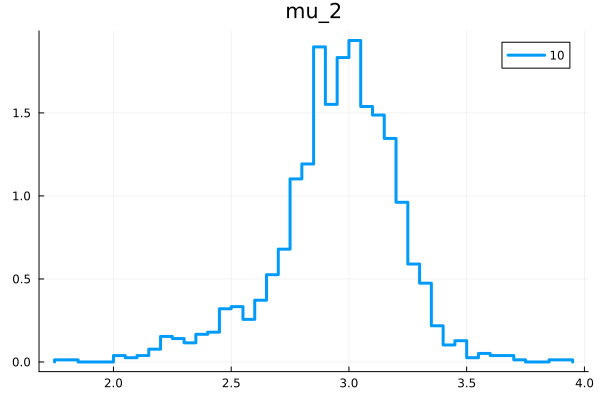

In [10]:
choice_iter = 10
plot(arr_df[choice_iter+1][:,choice_parameter], 
        label=choice_iter, title=string(choice_parameter),
        seriestype=:stephist, normed=true, linewidth=3)

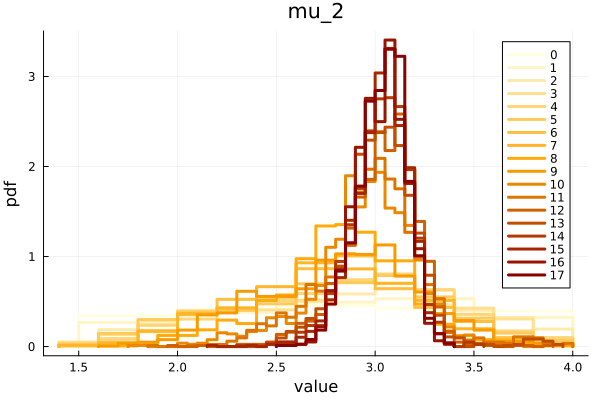

In [11]:
plot()
for choice_iter in 1:nb_iter+1
    plot!(arr_df[choice_iter][:,choice_parameter],  seriestype=:stephist, normed=true, linewidth=3, 
        label=choice_iter-1,
        color=palette(palette(:heat, nb_iter+1), nb_iter+1)[choice_iter])
end
plot!(xlabel="value", ylabel="pdf", title=string(choice_parameter))

In [12]:
#Save all fig
for choice_parameter in list_params
    plot()
    for choice_iter in 1:nb_iter+1
        plot!(arr_df[choice_iter][:,choice_parameter],  seriestype=:stephist, normed=true, linewidth=3, 
            label=choice_iter-1,
            color=palette(palette(:heat, nb_iter+1), nb_iter+1)[choice_iter])
    end
    plot!(xlabel="value", ylabel="pdf", title=string(choice_parameter), dpi=300)
    savefig("sensitivity_analysis$id_config/intermediate_distrib_$choice_parameter")
end

# Distance between intermediate posteriors

In [13]:
using OptimalTransport
using Distances
using LinearAlgebra

In [14]:
wasserstein_distance = Dict()
for choice_parameter in list_params
    wasserstein_distance[choice_parameter] = zeros(nb_iter+1)
    for choice_iter in 1:nb_iter
        samples_previous_iter = arr_df[choice_iter][:,choice_parameter] 
        samples_current_iter = arr_df[choice_iter+1][:,choice_parameter]
    
        C = pairwise(Euclidean(), samples_previous_iter', samples_current_iter', dims=2)
    
        # Adjust for the size of the samples
        p_masses = fill(1.0 / length(samples_previous_iter), length(samples_previous_iter))
        q_masses = fill(1.0 / length(samples_current_iter), length(samples_current_iter))
    
        ε = 0.01  # Regularization
        wasserstein_distance[choice_parameter][choice_iter] = sinkhorn2(p_masses, q_masses, C, ε, maxiter=50000)
    end

    #Lastly, distance between final iter and prior

    samples_prior = arr_df[1][:,choice_parameter] 
    samples_posterior = arr_df[nb_iter+1][:,choice_parameter]

    C = pairwise(Euclidean(), samples_prior', samples_posterior', dims=2)

    # Adjust for the size of the samples
    prior_masses = fill(1.0 / length(samples_prior), length(samples_prior))
    posterior_masses = fill(1.0 / length(samples_posterior), length(samples_posterior))

    ε = 0.01  # Regularization
    wasserstein_distance[choice_parameter][end] = sinkhorn2(prior_masses, posterior_masses, C, ε, maxiter=50000)

    
end

In [15]:
wasserstein_distance

Dict{Any, Any} with 17 entries:
  :p2_3            => [0.0213793, 0.0142638, 0.0169919, 0.0137332, 0.0168546, 0…
  :mu_3            => [0.135713, 0.043135, 0.060004, 0.0682818, 0.0799379, 0.04…
  :sig_4           => [0.0255035, 0.0139759, 0.0182836, 0.0224597, 0.0230366, 0…
  :sig_2           => [0.0187686, 0.0144737, 0.0240698, 0.0126478, 0.0123473, 0…
  :mu_2            => [0.0714578, 0.0457179, 0.0627655, 0.0387297, 0.0578057, 0…
  :p1_3            => [0.0184077, 0.0129015, 0.0140442, 0.0182554, 0.0227599, 0…
  :p1_1            => [0.0232211, 0.0138183, 0.0128113, 0.0171774, 0.0138793, 0…
  :p1_2            => [0.0301416, 0.0122109, 0.0204405, 0.0190505, 0.0123993, 0…
  :sig_3           => [0.0197771, 0.0151686, 0.0142295, 0.0130288, 0.0113206, 0…
  :sig_1           => [0.0181284, 0.0117961, 0.0140794, 0.0130921, 0.0130372, 0…
  :p2_2            => [0.0291084, 0.0144895, 0.0208743, 0.0159643, 0.0144436, 0…
  :p3_3            => [0.0192307, 0.0188131, 0.0164067, 0.0142383, 0.0492986,

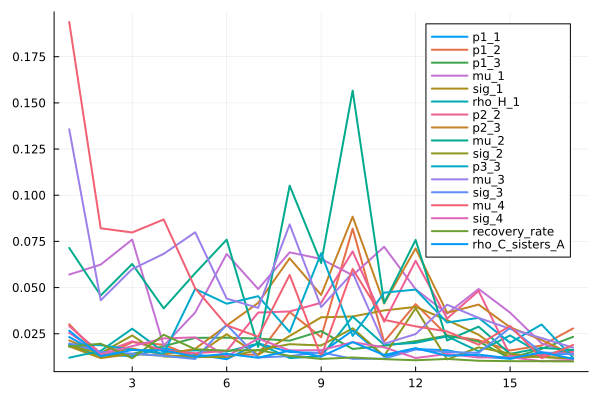

In [16]:
plot()
for choice_parameter in list_params 
    plot!(wasserstein_distance[choice_parameter][1:end-1], label=string(choice_parameter), linewidth=2)
end
plot!()

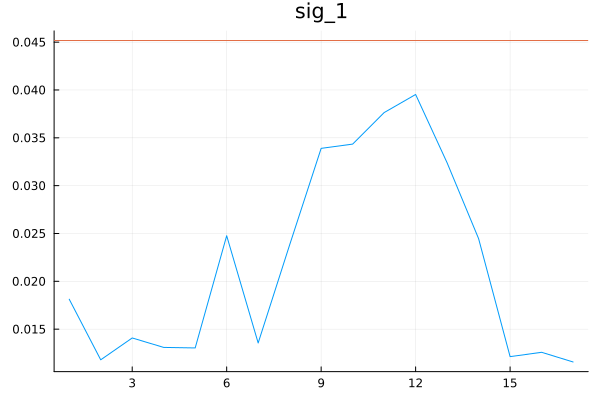

In [17]:
choice_parameter = :sig_1
plot(title=string(choice_parameter))
plot!(wasserstein_distance[choice_parameter][1:end-1], label="")
#plot!([sum(wasserstein_distance[choice_parameter][1:i]) for i in 1:nb_iter], label="")
hline!([wasserstein_distance[choice_parameter][end]], label="")

# Parameters by groups

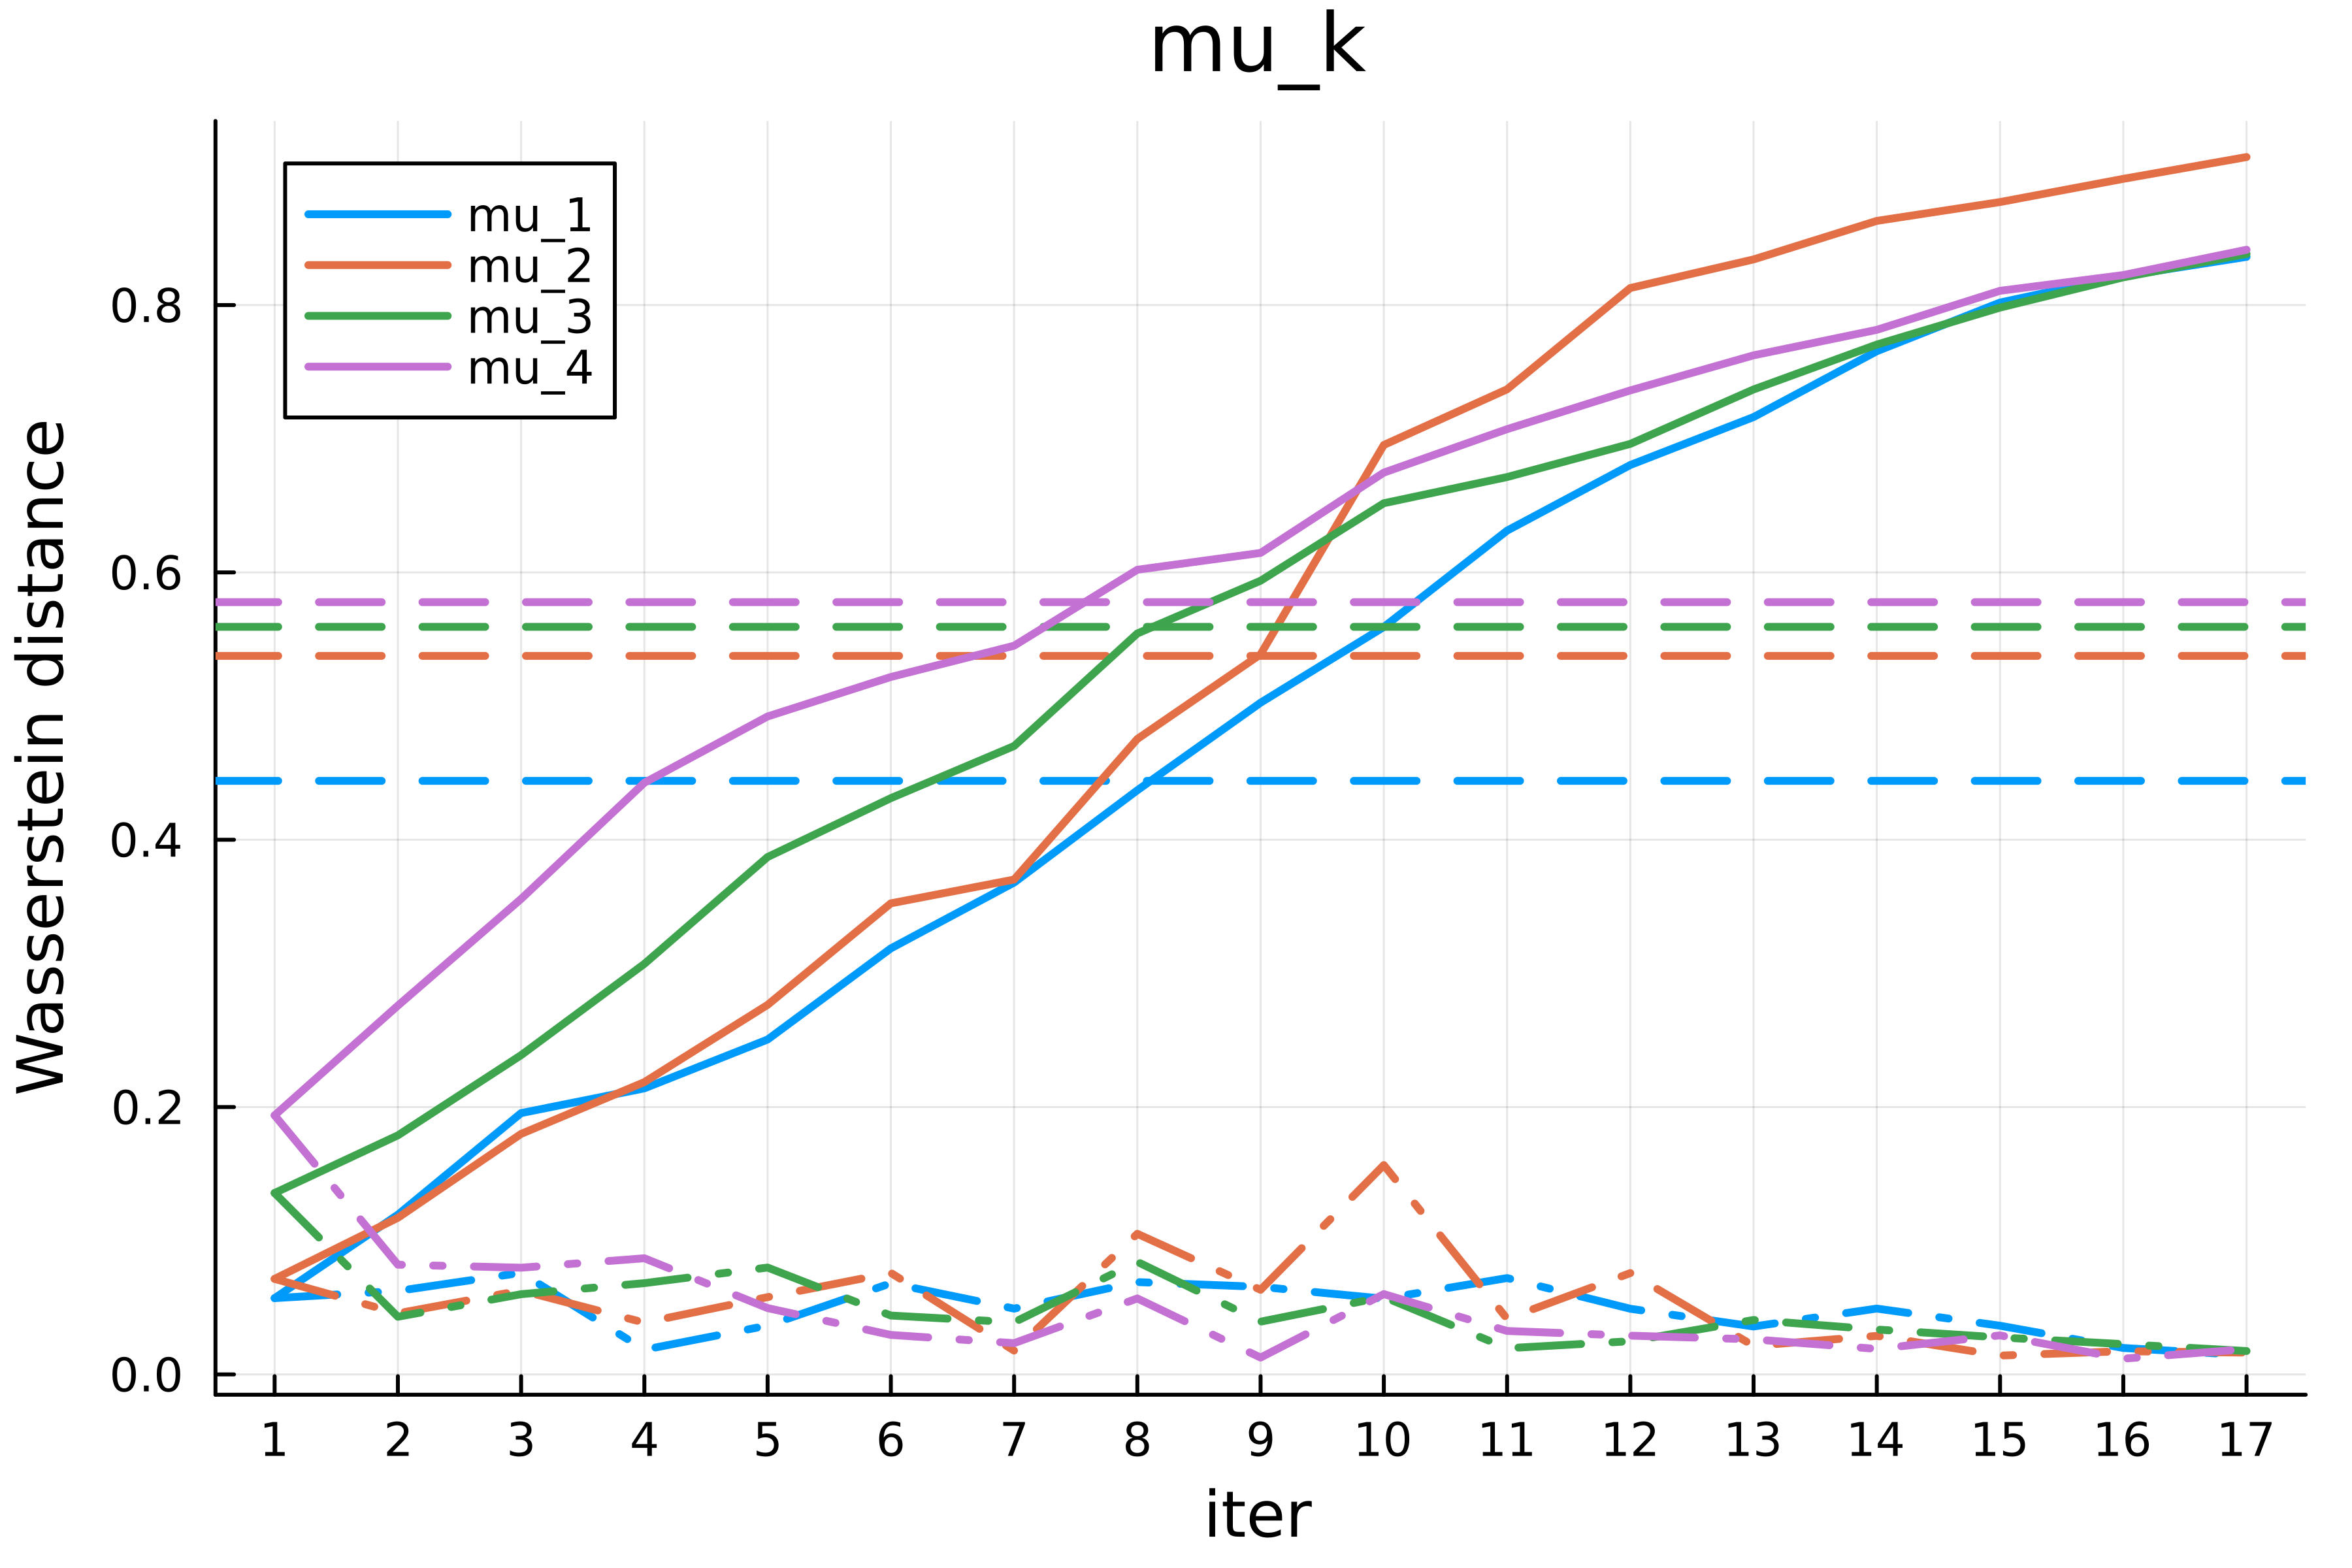

In [18]:
plot(title="mu_k")
for i in 1:4
    
    choice_parameter = Symbol(string("mu_",i))
    plot!(wasserstein_distance[choice_parameter][1:end-1], label="", color=i, linewidth=2, linestyle=:dashdot)
    plot!([sum(wasserstein_distance[choice_parameter][1:i]) for i in 1:nb_iter], label=string(choice_parameter), color=i, linestyle=:solid, linewidth=2)
    hline!([wasserstein_distance[choice_parameter][end]], label="", color=i, linewidth=2, linestyle=:dash)
end
plot!(xticks=collect(1:nb_iter), xlabel="iter", ylabel = "Wasserstein distance", dpi=600)
savefig("./sensitivity_analysis/wasserstein_mu")
plot!()


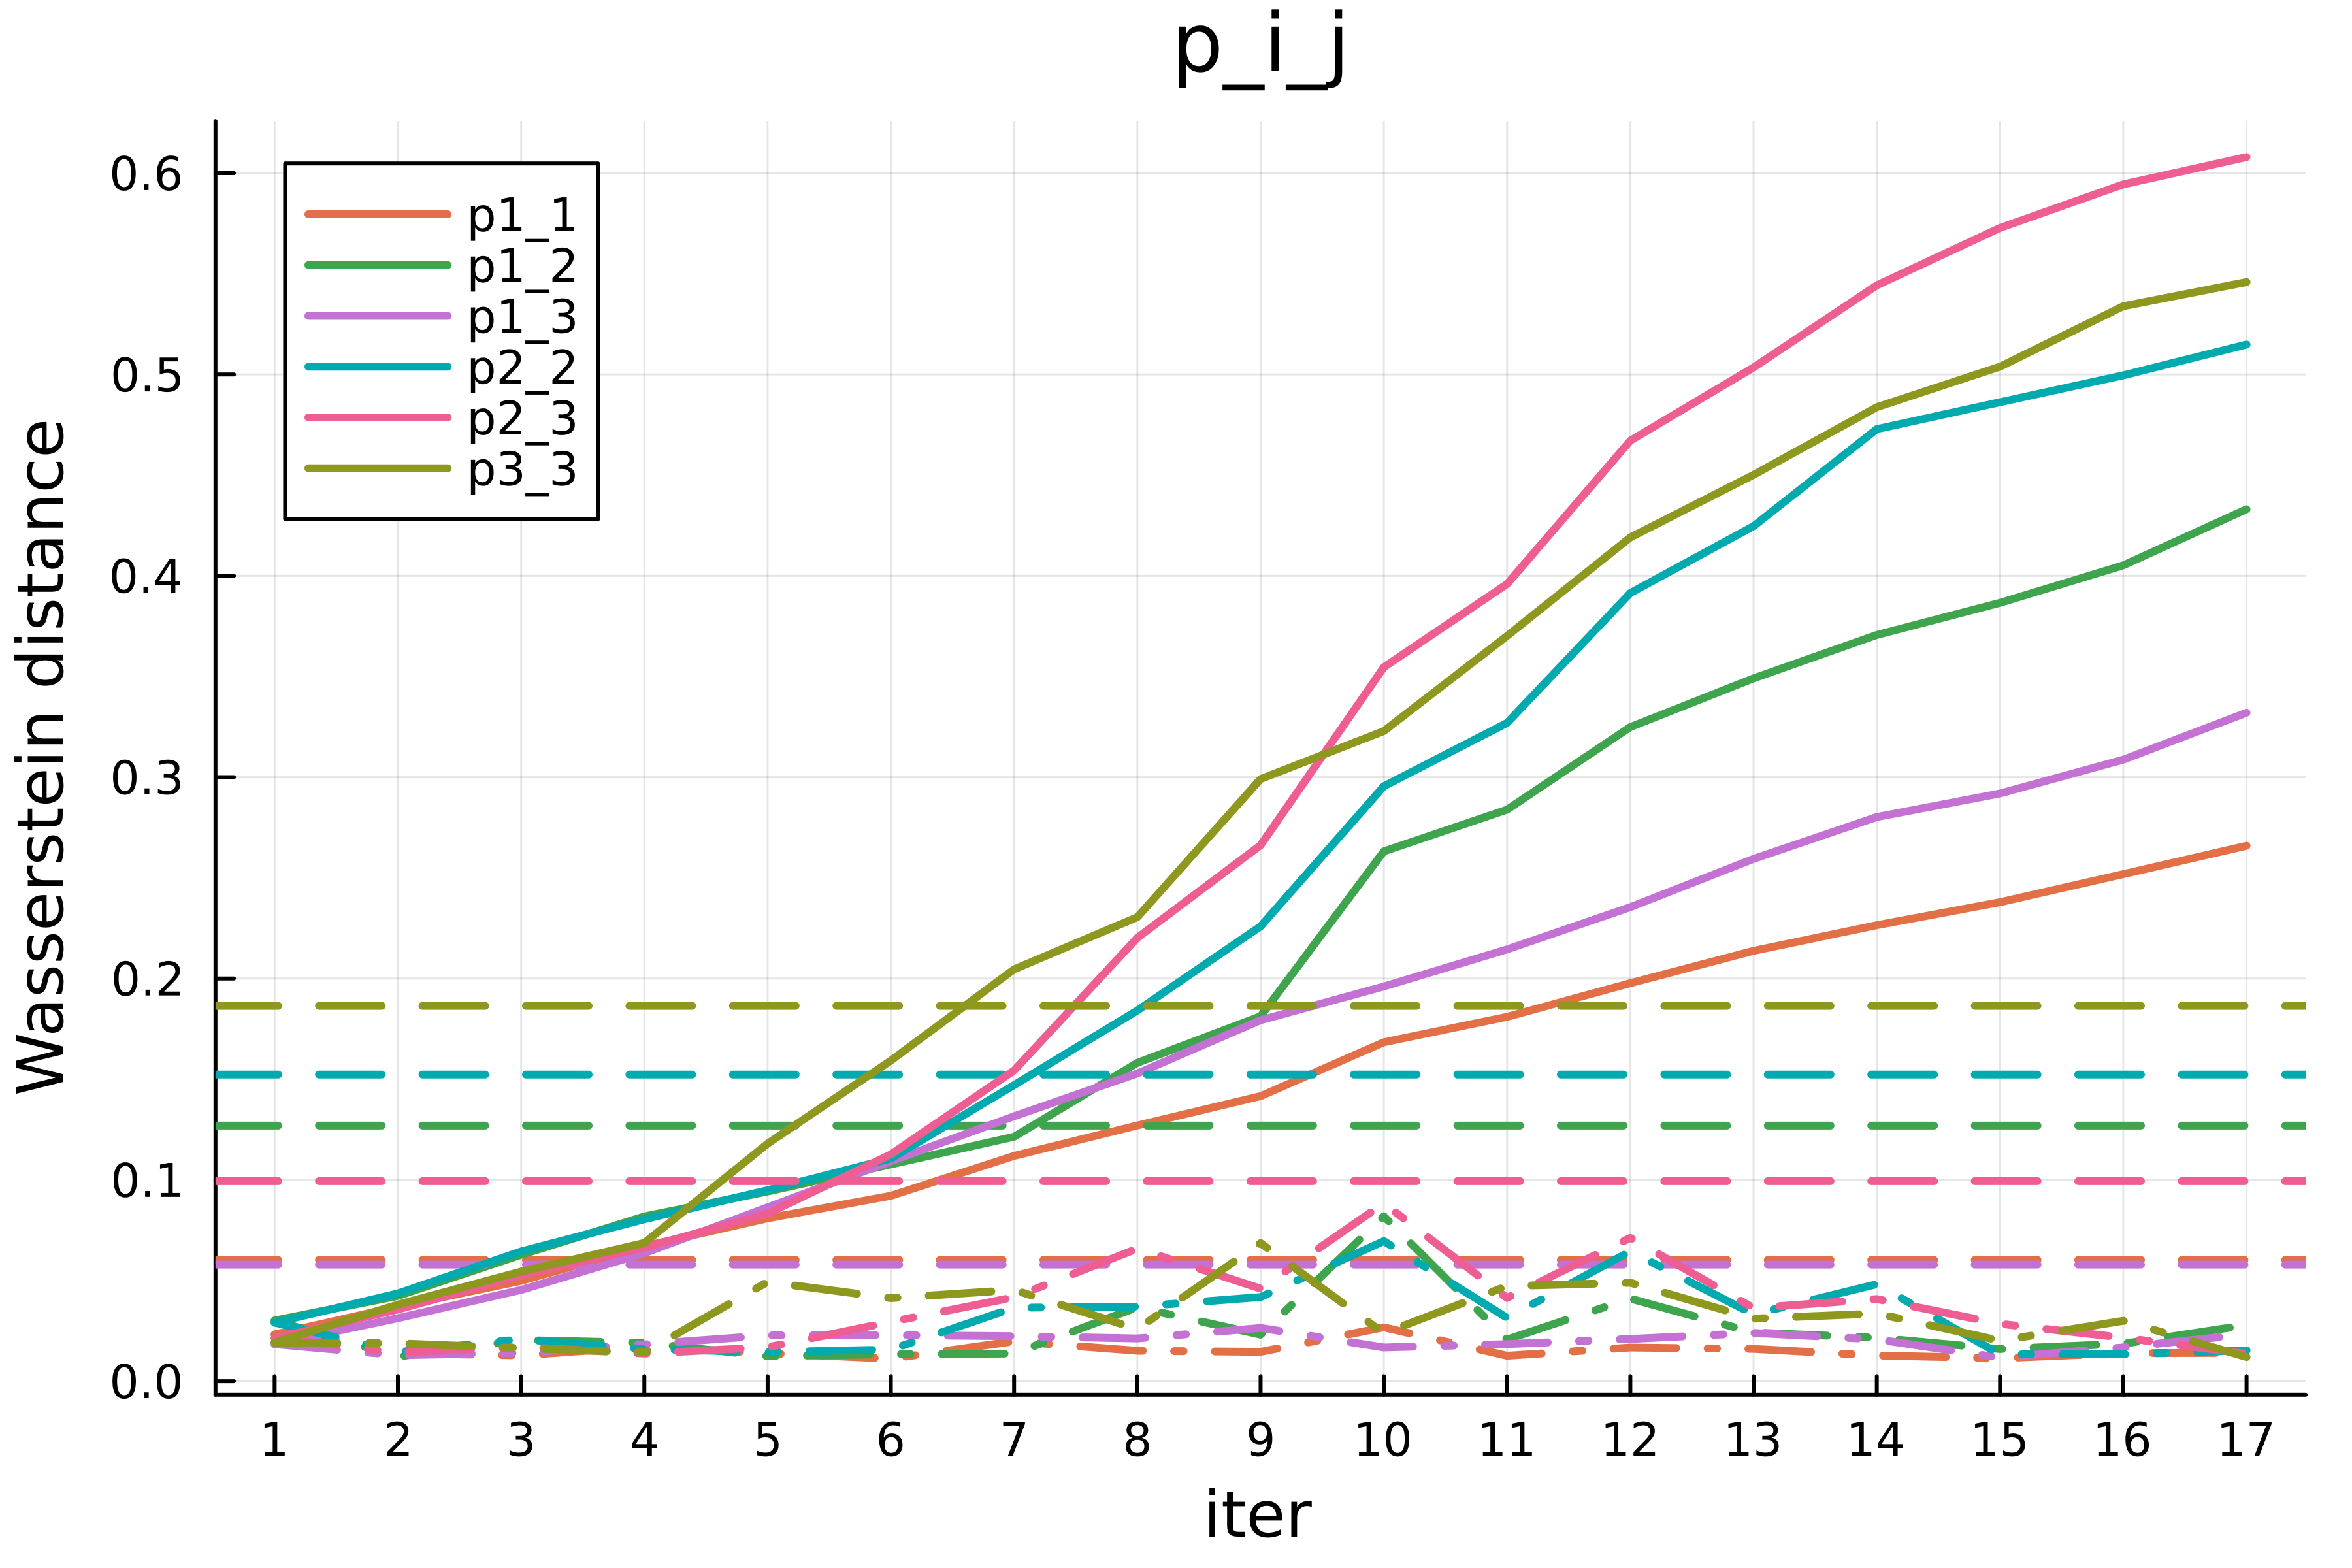

In [19]:
plot(title="p_i_j")
for i in 1:3
    for j in i:3
        ind_color = (3*(i-1)+j+1)
        choice_parameter = Symbol(string("p",i,"_",j))
        plot!(wasserstein_distance[choice_parameter][1:end-1], label="", color=ind_color, linewidth=2, linestyle=:dashdot)
        plot!([sum(wasserstein_distance[choice_parameter][1:i]) for i in 1:nb_iter], 
            label=string(choice_parameter), color=ind_color, linestyle=:solid, linewidth=2)
        hline!([wasserstein_distance[choice_parameter][end]], label="", color=ind_color, linewidth=2, linestyle=:dash)
    end
end
plot!(xticks=collect(1:nb_iter), xlabel="iter", ylabel = "Wasserstein distance", dpi=600)
savefig("./sensitivity_analysis/wasserstein_pi_j")
plot!()


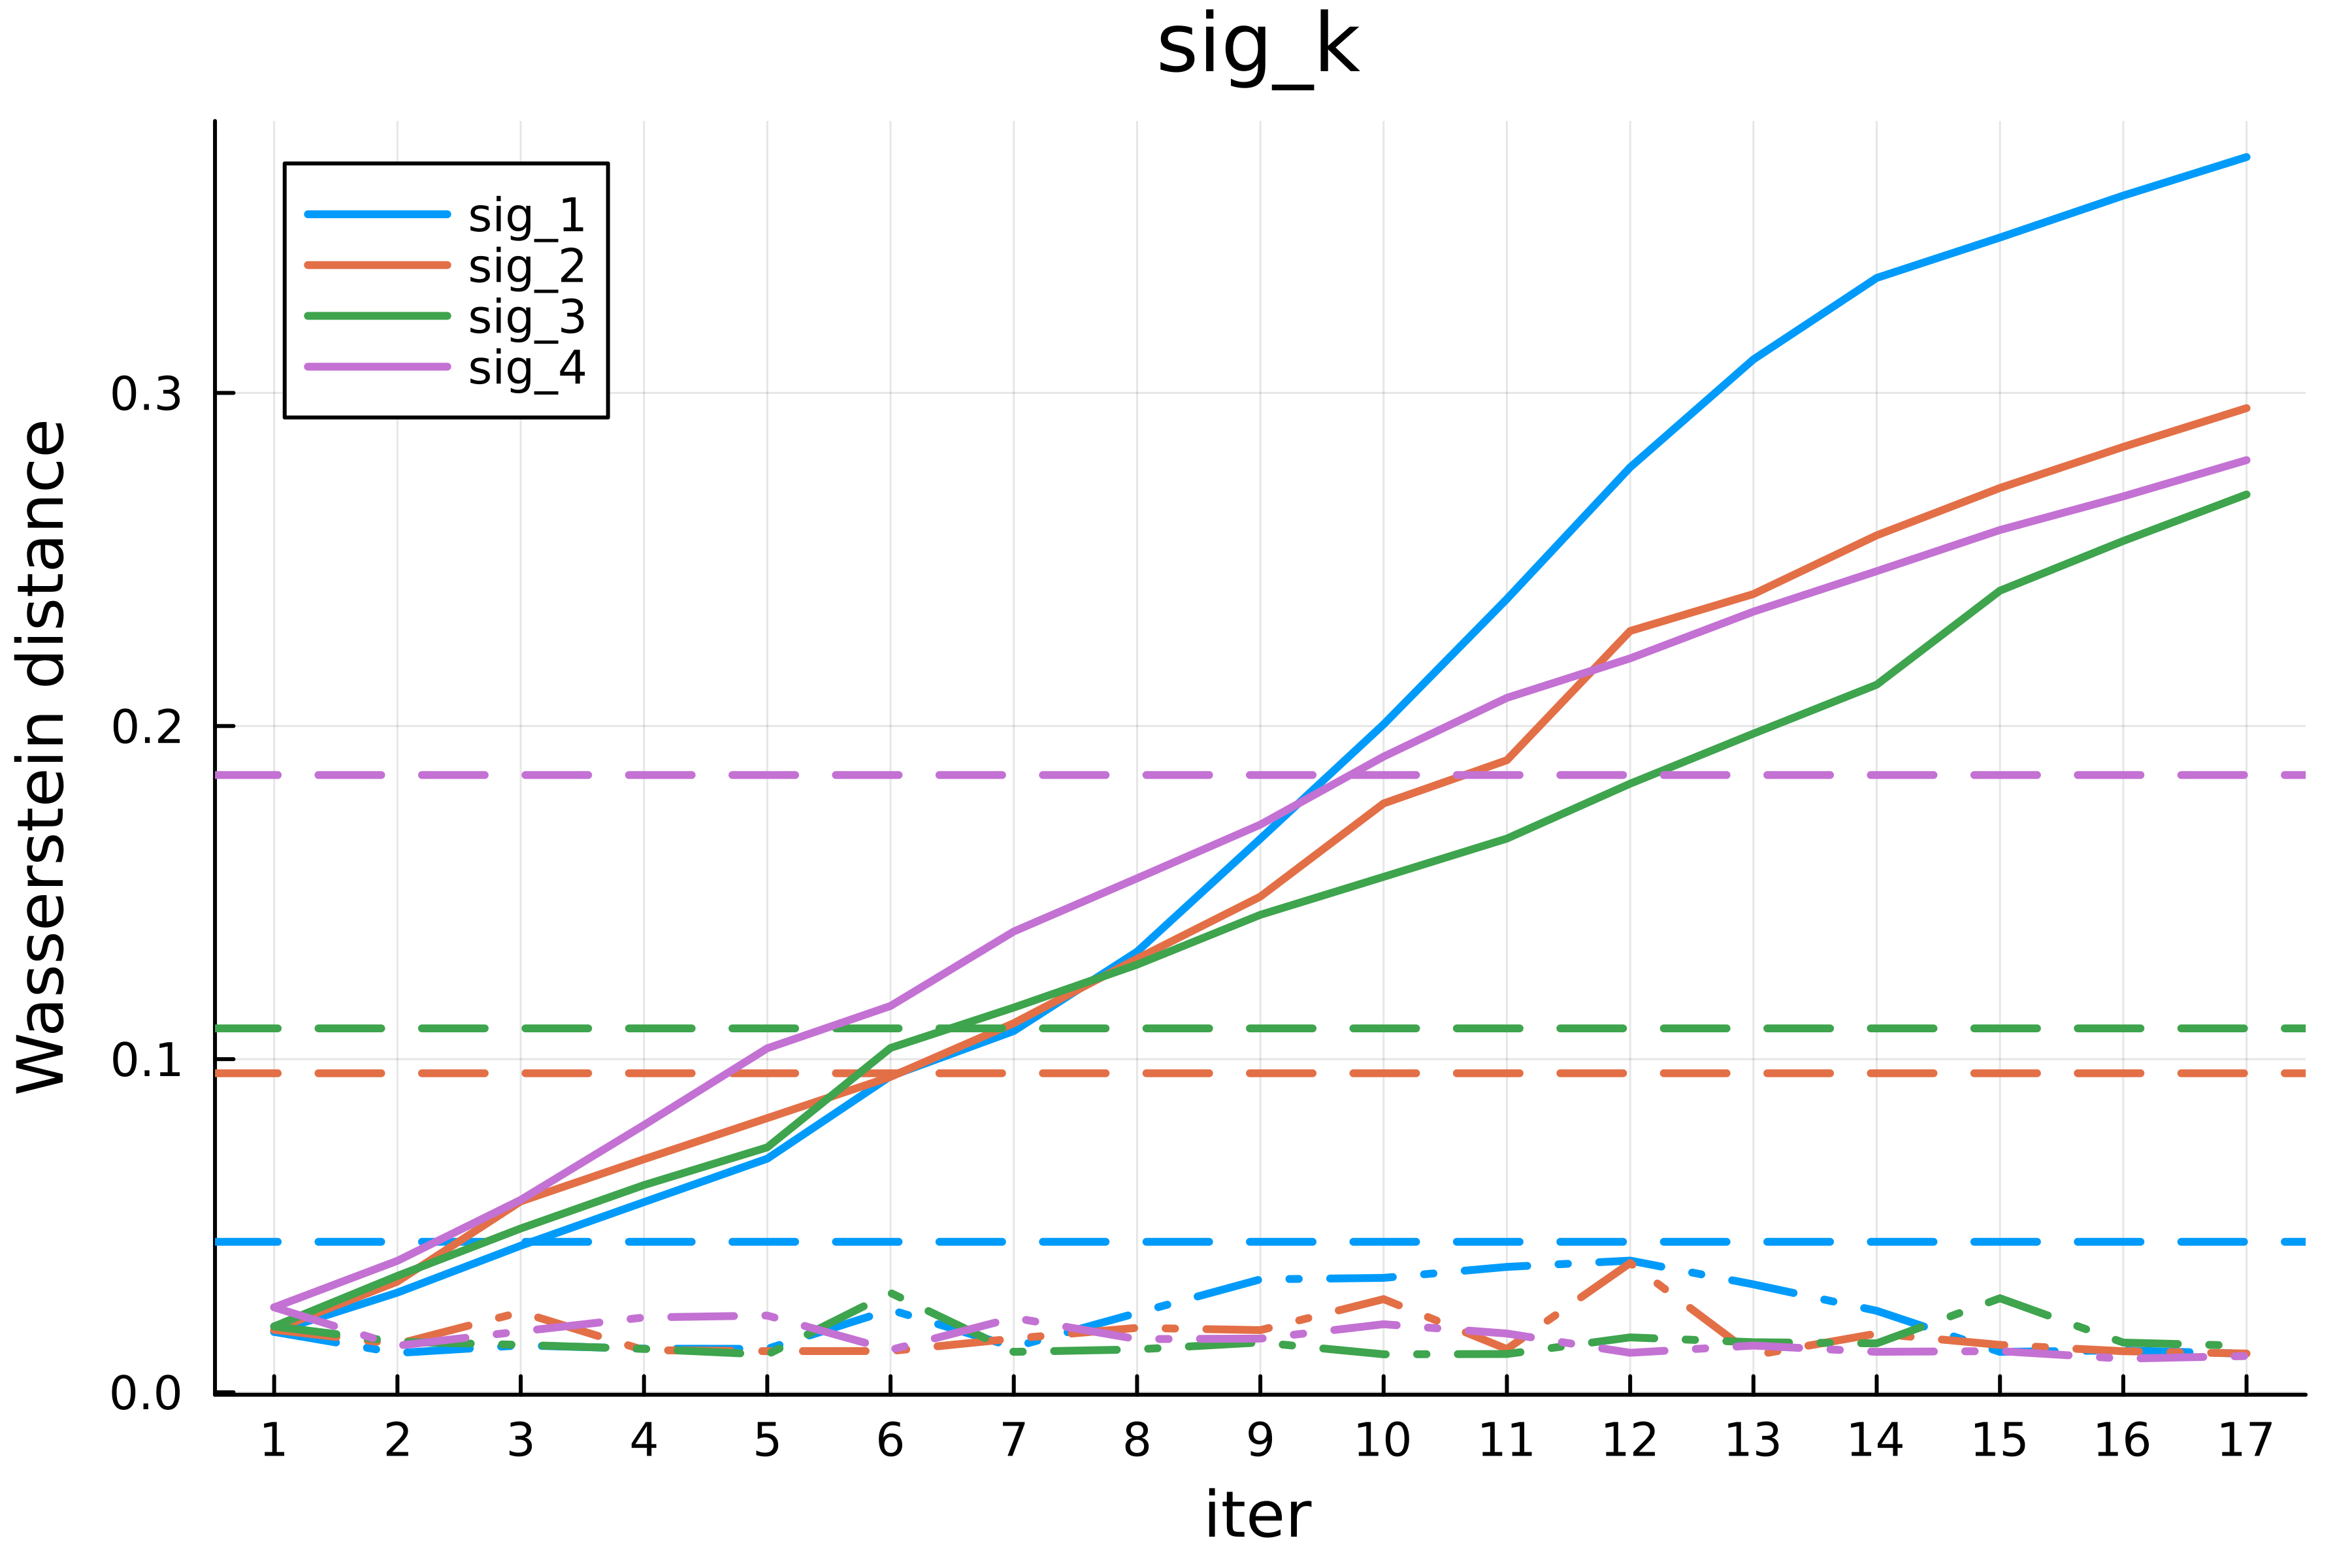

In [20]:
plot(title="sig_k")
for i in 1:4
    
    choice_parameter = Symbol(string("sig_",i))
    plot!(wasserstein_distance[choice_parameter][1:end-1], label="", color=i, linewidth=2, linestyle=:dashdot)
    plot!([sum(wasserstein_distance[choice_parameter][1:i]) for i in 1:nb_iter], label=string(choice_parameter), color=i, linestyle=:solid, linewidth=2)
    hline!([wasserstein_distance[choice_parameter][end]], label="", color=i, linewidth=2, linestyle=:dash)
end
plot!(xticks=collect(1:nb_iter), xlabel="iter", ylabel = "Wasserstein distance", dpi=600)
savefig("./sensitivity_analysis/wasserstein_sig")
plot!()


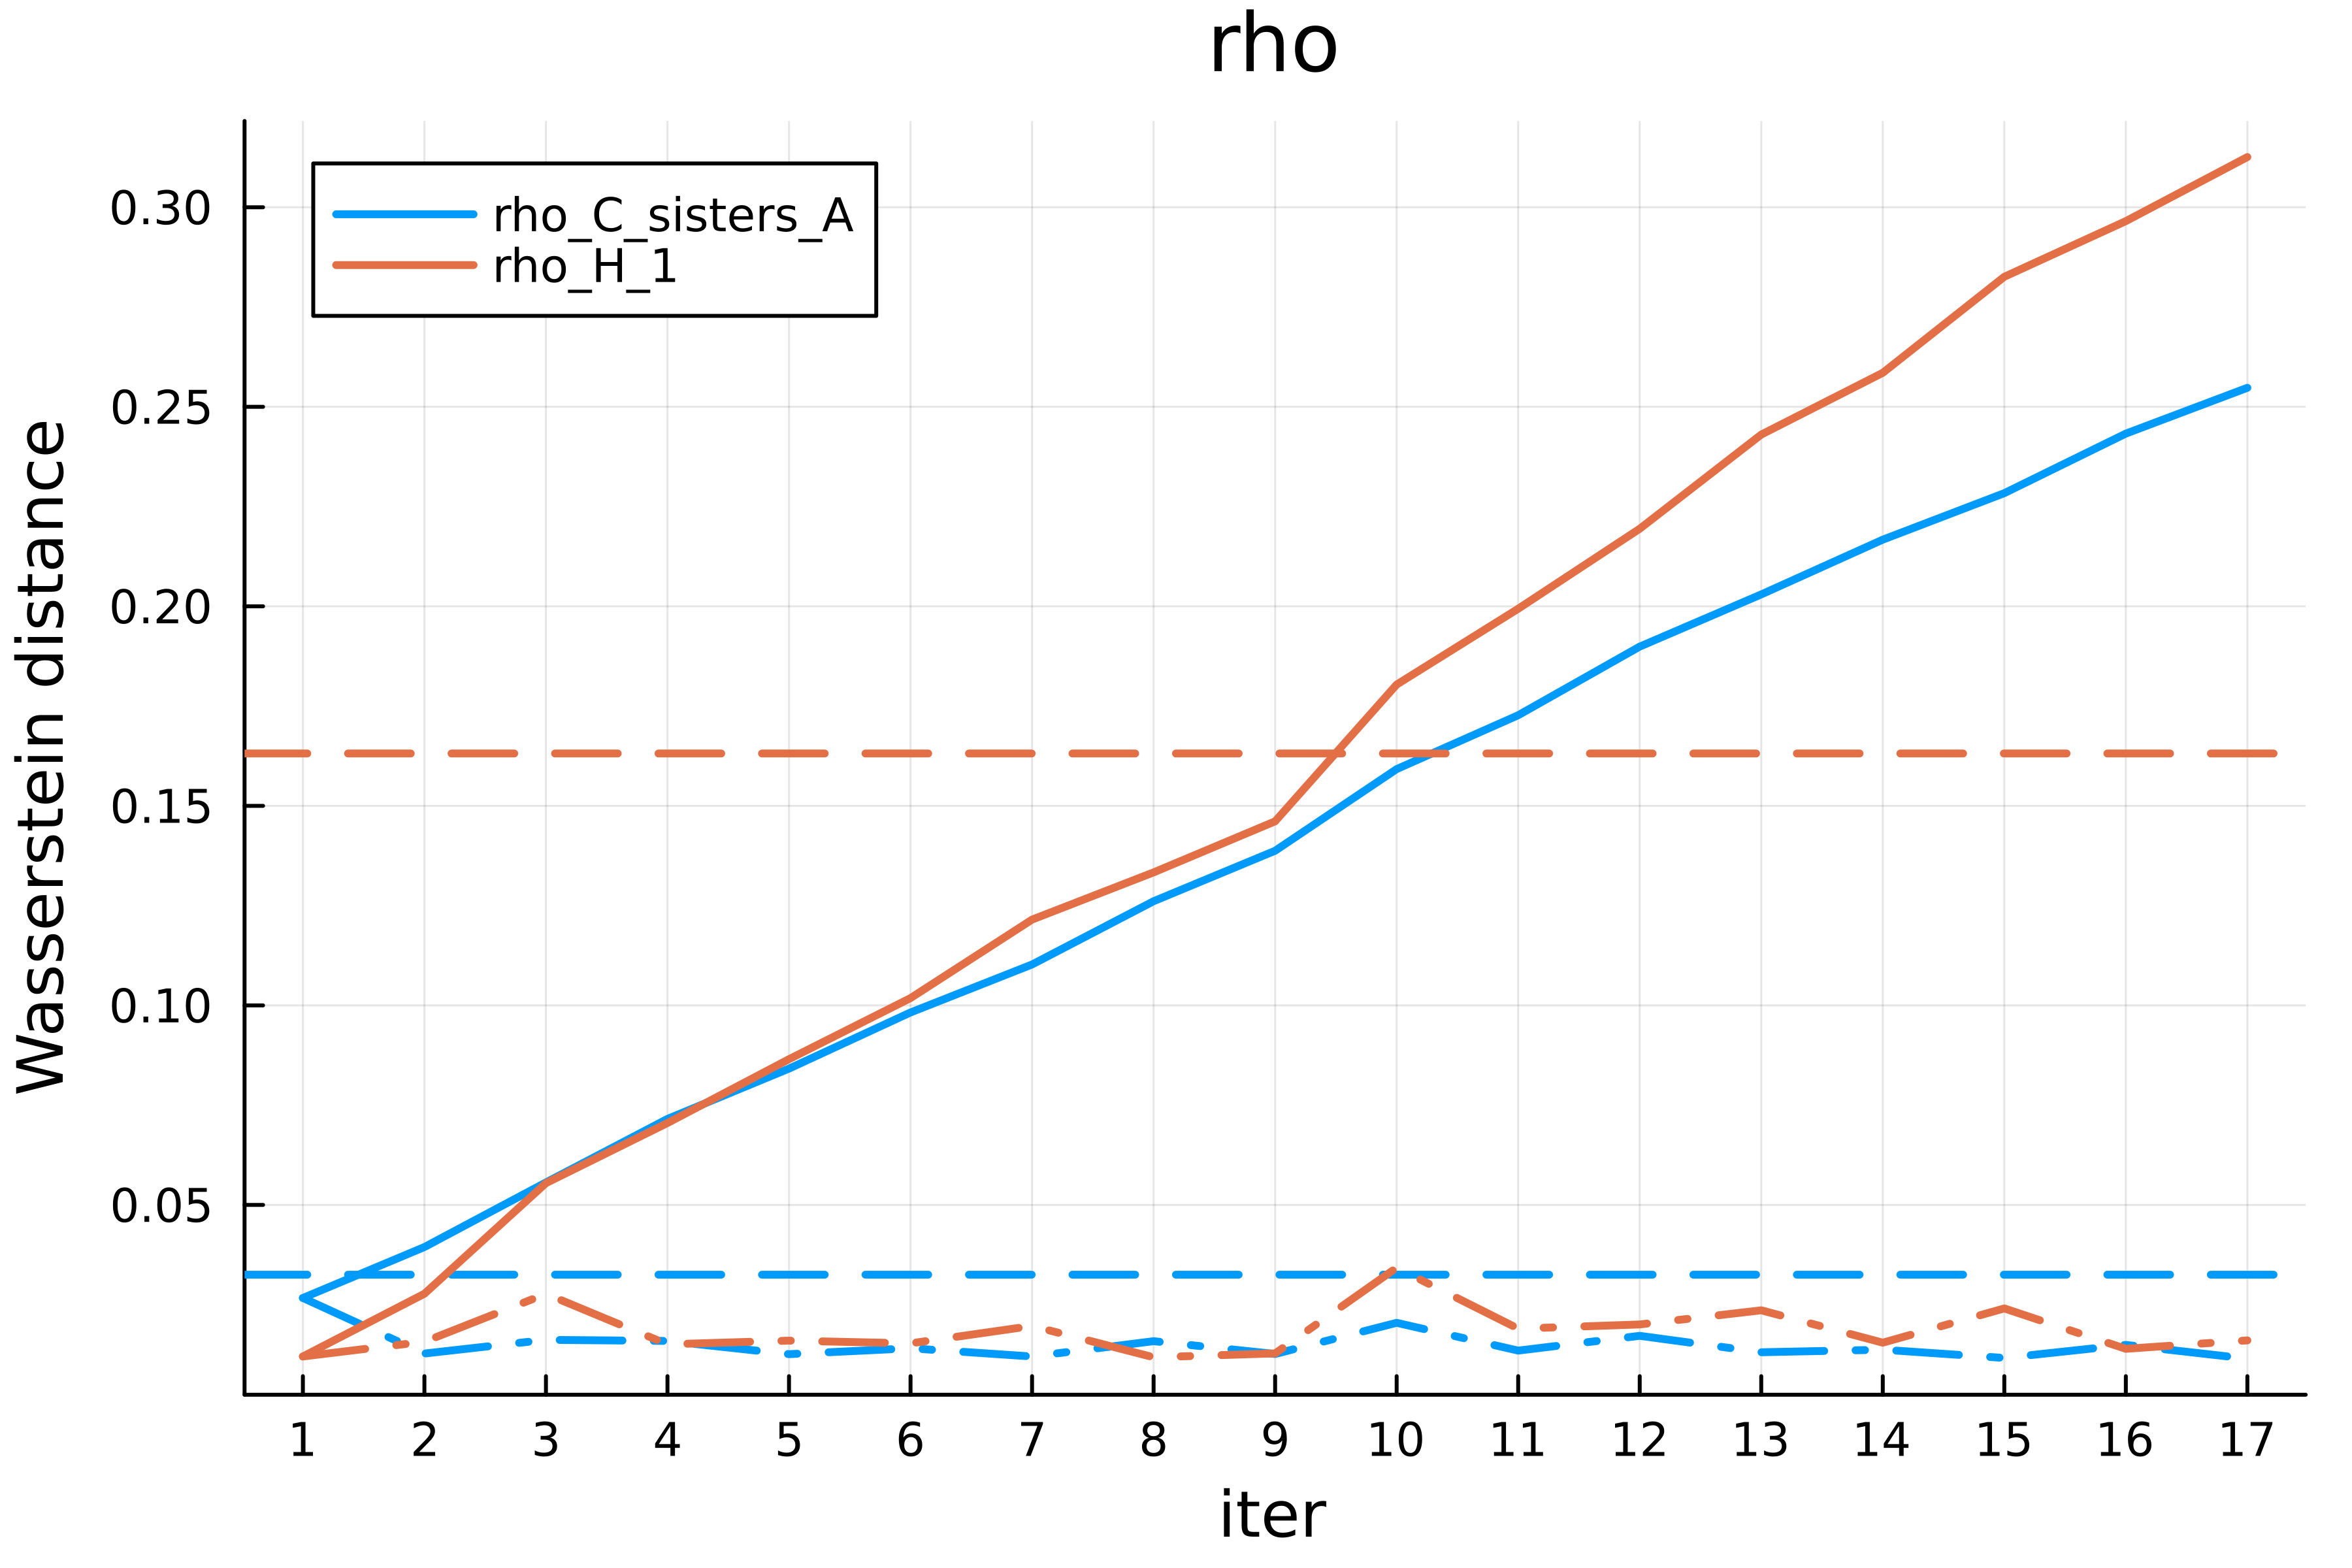

In [21]:
plot(title="rho")
for i in 1:2
    
    choice_parameter = [:rho_C_sisters_A, :rho_H_1][i]
    plot!(wasserstein_distance[choice_parameter][1:end-1], label="", color=i, linewidth=2, linestyle=:dashdot)
    plot!([sum(wasserstein_distance[choice_parameter][1:i]) for i in 1:nb_iter], label=string(choice_parameter), color=i, linestyle=:solid, linewidth=2)
    hline!([wasserstein_distance[choice_parameter][end]], label="", color=i, linewidth=2, linestyle=:dash)
end
plot!(xticks=collect(1:nb_iter), xlabel="iter", ylabel = "Wasserstein distance", dpi=600)
savefig("./sensitivity_analysis/wasserstein_rho")
plot!()


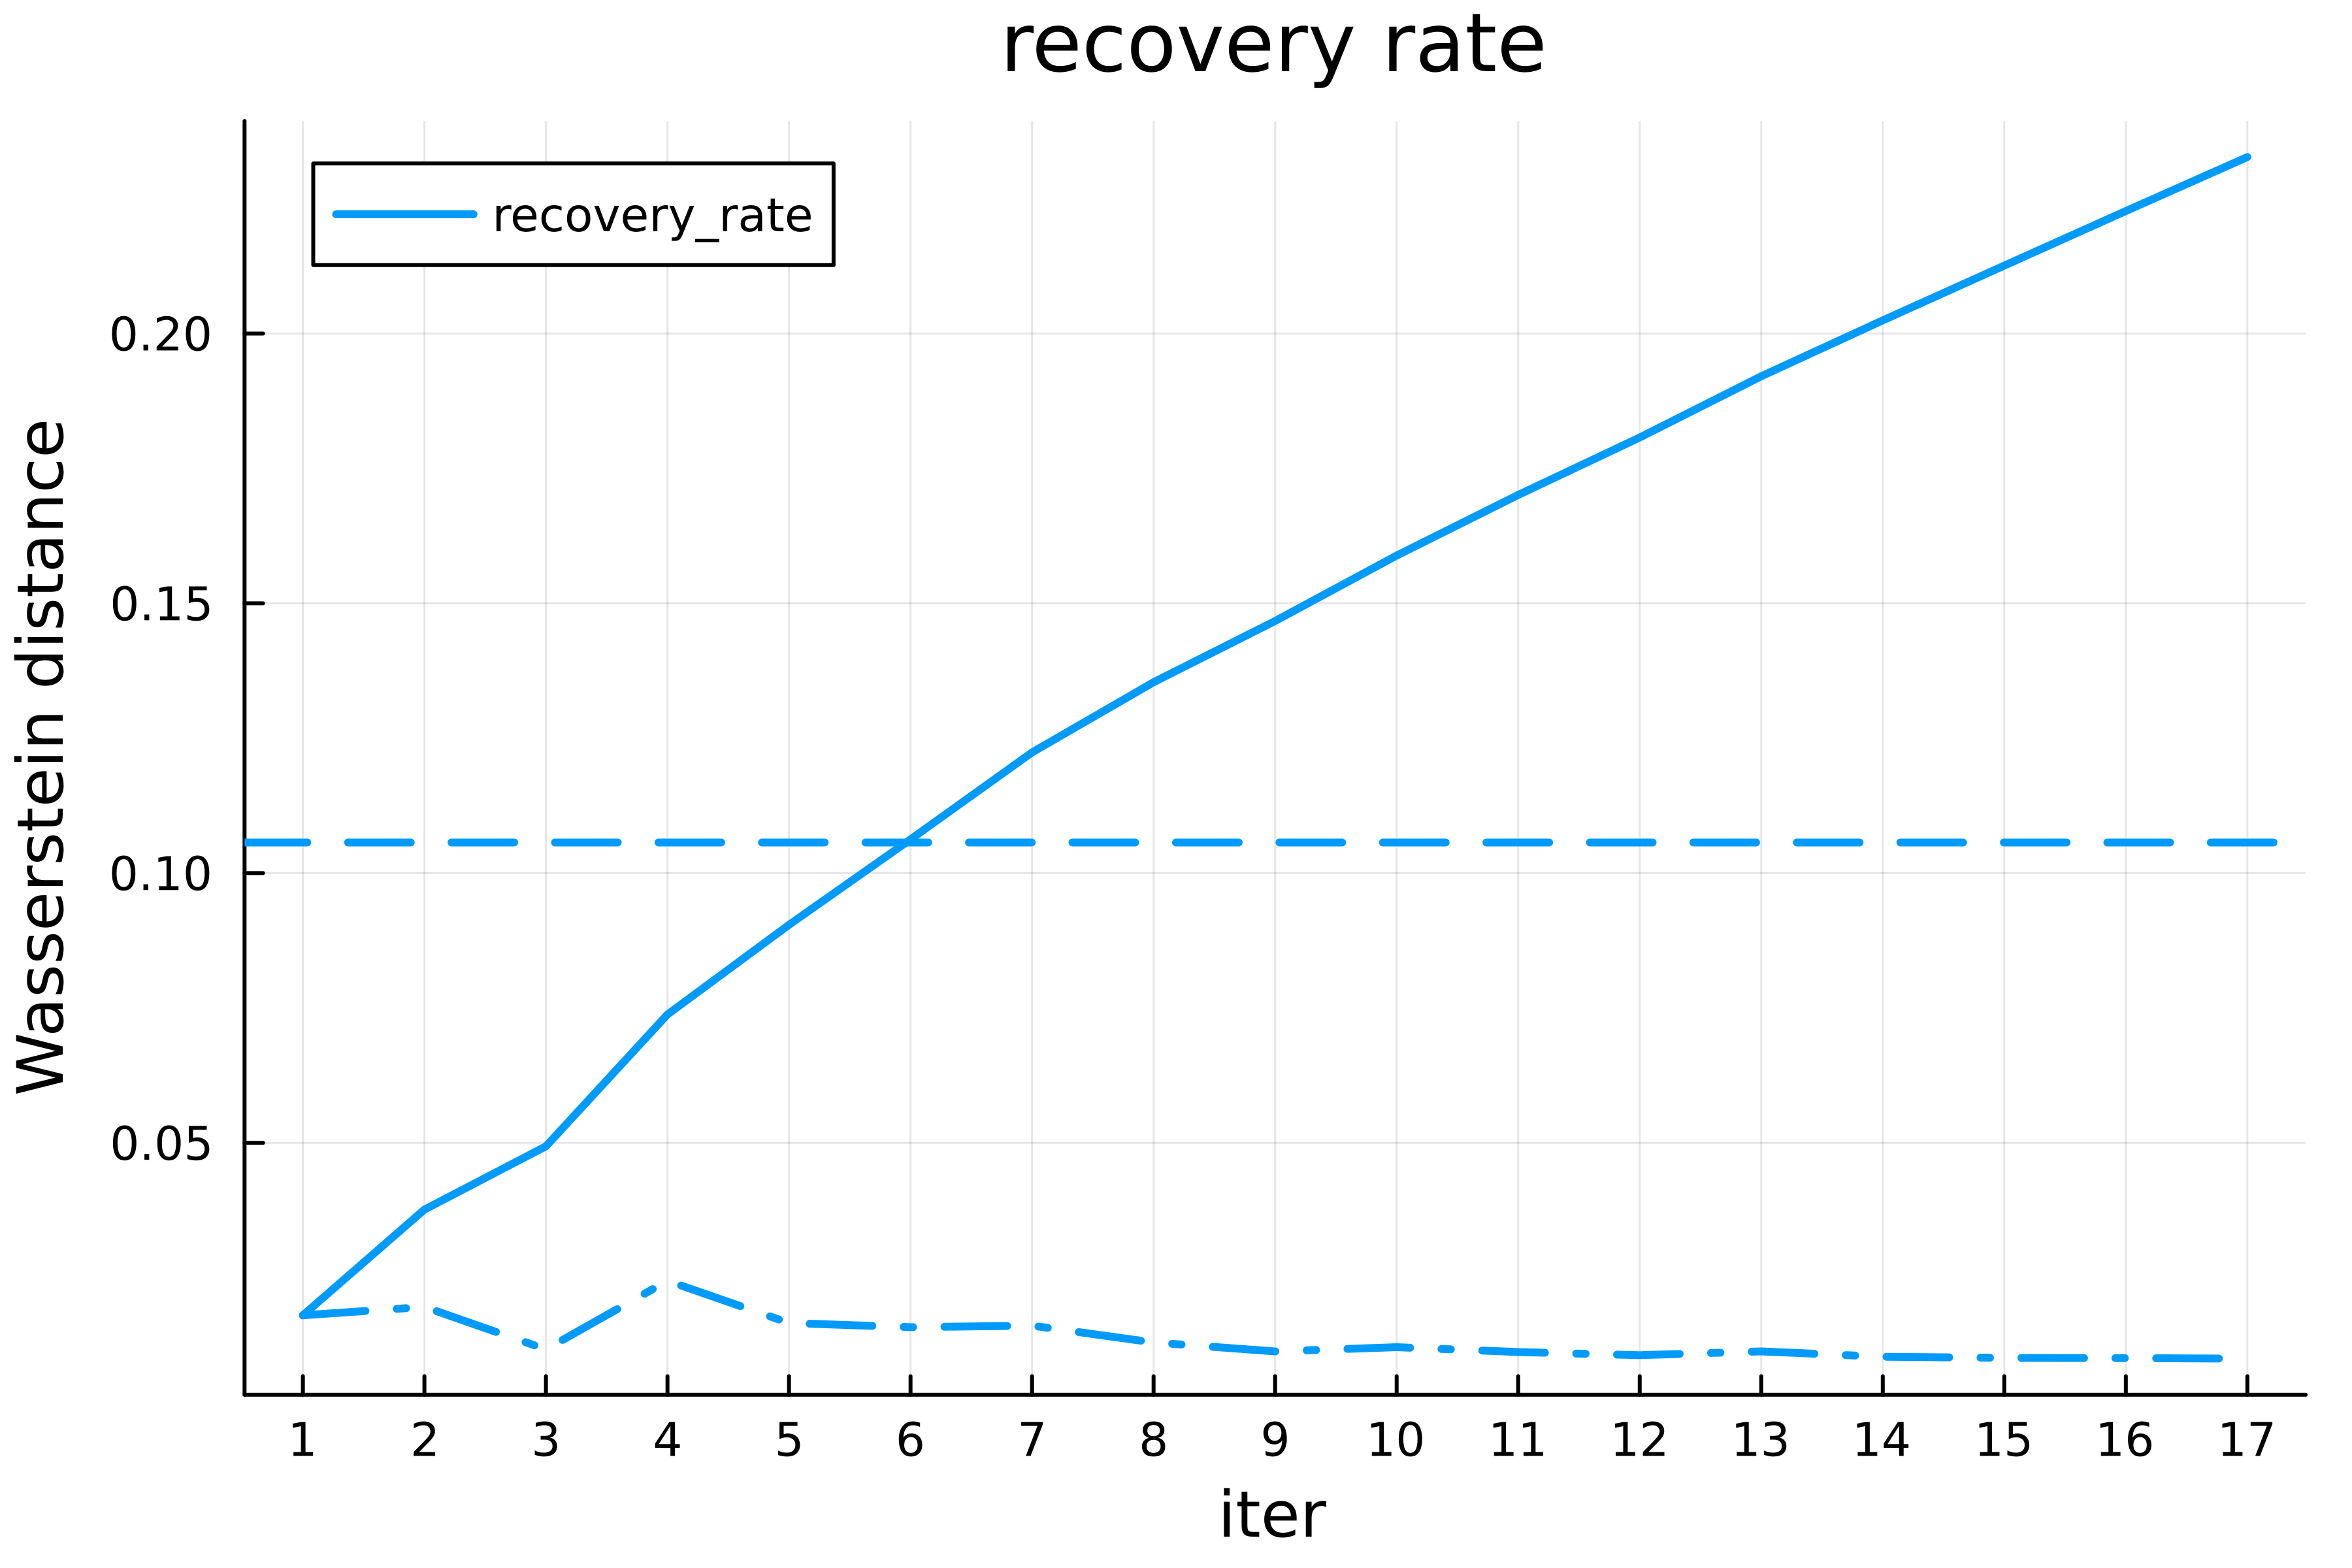

In [22]:
plot(title="recovery rate")
    
    choice_parameter = :recovery_rate
    plot!(wasserstein_distance[choice_parameter][1:end-1], label="", color=1, linewidth=2, linestyle=:dashdot)
    plot!([sum(wasserstein_distance[choice_parameter][1:i]) for i in 1:nb_iter], label=string(choice_parameter), color=1, linestyle=:solid, linewidth=2)
    hline!([wasserstein_distance[choice_parameter][end]], label="", color=1, linewidth=2, linestyle=:dash)

plot!(xticks=collect(1:nb_iter), xlabel="iter", ylabel = "Wasserstein distance", dpi=600)
savefig("./sensitivity_analysis/wasserstein_eta")
plot!()